## H.4 SMC Sampler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def target(x1, x2):
    # Computing pdf of unnormalized target distribution
    ind_x1 = (x1 >= 0.0) & (x1 <= 1.0) 
    ind_x2 = (x2 >= 0.0) & (x2 <= 1.0)
    return ind_x1 * ind_x2 * np.cos(x1 * np.pi)**2 * np.sin(x2 * 3 * np.pi)**6 * np.exp(-30*(x1**2 + x2**2))

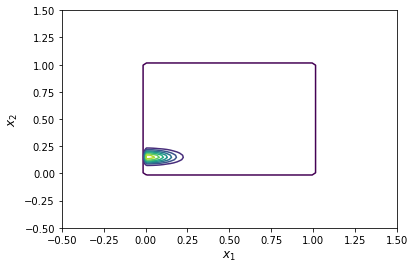

In [3]:
x = np.linspace(-.5, 1.5, 100); y = np.linspace(-.5, 1.5, 100)
X, Y = np.meshgrid(x, y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = target(x1=pos[:, :, 0], x2=pos[:, :, 1])
plt.contour(X, Y, Z)
plt.xlabel("$x_1$", fontsize=12); plt.ylabel("$x_2$", fontsize=12)
plt.show()

In [36]:
def log_target(x1, x2):
    ind_x1 = (x1 >= 0.0) & (x1 <= 1.0) 
    ind_x2 = (x2 >= 0.0) & (x2 <= 1.0)
    return ind_x1 * ind_x2 * (2*np.log(np.cos(x1 * np.pi)) + 
                              6 * np.log(np.sin(x2 * 3 * np.pi)) - 30*(x1**2 + x2**2) ) 

def tempered_logpdf(x, k, K):
    return (k / K) * log_target(x[0], x[1]) #- \
                #multivariate_normal.logpdf(x, mean=np.zeros(2), cov=np.eye(2))

In [33]:
def mcmc_kernel(x, k, K, tau):
    # Sample from proposal distribution
    x_prop = multivariate_normal.rvs(mean=x, cov=tau**2 * np.eye(2), size=1)
    
    # Since the proposal is a gaussian random walk, the second terms
    # in the acceptance probability will cancel out
    u = np.random.uniform(0.0, 1.0, size=1)
    
    log_alpha = np.minimum(0.0, tempered_logpdf(x_prop, k, K) - tempered_logpdf(x, k, K))
    
    if np.log(u) <= log_alpha:
        return x_prop, np.exp(log_alpha)
    else:
        return x, np.exp(log_alpha)

In [34]:
def smc_sampler(K, N, ess_trigger, tau):
    # Initialization
    x = np.zeros([K+1, N, 2])
    ancs = np.zeros([K, N], dtype=int)
    w = np.zeros([K+1, N])
    
    x[0, :, :] = multivariate_normal.rvs(mean=np.zeros(2), cov=np.eye(2), size=N)
    w[0, :] = np.ones(N) / N
    Z_hat = 0.0
    Z0 = np.sqrt(2*np.pi) # since p(x0) is zero-mean Gaussian with identity matrix as covariance
    
    for k in range(1, K+1):
        
        # Set weights
        for i in range(N):
            w[k, i] = np.log(w[k-1, i]) + tempered_logpdf(x[k-1, i, :], k, K) - \
                        tempered_logpdf(x[k-1, i, :], k-1, K)
            print(tempered_logpdf(x[k-1, i, :], k, K))
        # Normalize the weights    
        w[k, :] -= np.max(w[k, :])
        w[k, :] = np.exp(w[k, :]) / np.sum(np.exp(w[k, :]))
        
        # If ESS too low, resample and set weights to 1/N
        N_ess = 1/(np.sum(w[k, :])**2)
        if N_ess < ess_trigger:
            ancs[k-1, :] = np.random.choice(N, size=N, p=w[k, :])
            w[k, :] = np.ones(N) / N
        else:
            ancs[k-1, :] = range(N)

        # Sample x_k from MCMC kernel
        for i in range(N):
            x[k, i, :], alpha = mcmc_kernel(x[k-1, ancs[k-1, i], :], k, K, tau)
    
    #Z_hat = Z_hat - np.log(Z0)
    return x, w, ancs, Z_hat

In [37]:
N = 100
tau = 0.02
ess_trigger = 0.7*N
K = 2
x, w, ancs, Z_hat = smc_sampler(K, N, ess_trigger, tau)
print("Z_hat: ", Z_hat)

C:\Users\Marcus\Miniconda3\envs\smc\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\Users\Marcus\Miniconda3\envs\smc\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


nan
nan
nan
-2.1276012999814586
-3.716733208903991
nan
-5.237477238541084
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.342034929675897
nan
nan
nan
nan
nan
nan
nan
nan
-1.9999416993581942
nan
nan
-2.6072233618857994
nan
nan
nan
nan
-5.0306639039751895
nan
-4.055814241869927
nan
nan
nan
-1.956945564506765
nan
nan
nan
-19.0785424342484
-1.9390590177136975
nan
nan
-2.9022036690314392
-2.874715065736833
-2.8779843876967535
nan
nan
nan
nan
-3.0438305836792203
-3.406831923248053
nan
nan
-1.9344836320843222
nan
nan
nan
nan
-4.707453261146522
-3.2762301612209788
-4.0557013555484165
nan
nan
-5.001031067665027
-1.8887508958851384
-3.730587852533819
nan
nan
nan
nan
nan
nan
-1.9092928357425893
nan
nan
nan
-3.0143526296991174
-4.937492662125268
nan
nan
nan
-5.258829937183369
nan
-2.068339092840875
nan
-16.528730868059863
nan
nan
nan
nan
nan
-5.82552568224781
nan
nan
nan
-2.1515102775392707
-3.6929993715222285
nan
-5.237477238541084
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-4.38537473806

In [25]:
x

array([[[-1.96379044,  0.46674943],
        [-1.50344175, -0.36091691],
        [ 1.1077091 ,  0.33908935],
        ...,
        [-0.14262011, -0.20654709],
        [-1.37122604, -0.3853571 ],
        [ 0.52191607,  0.13373077]],

       [[-1.96379044,  0.46674943],
        [-1.5068634 , -0.36118524],
        [ 1.1077091 ,  0.33908935],
        ...,
        [-0.14262011, -0.20654709],
        [-1.37122604, -0.3853571 ],
        [ 0.52191607,  0.13373077]],

       [[-1.96379044,  0.46674943],
        [-1.51887668, -0.35593001],
        [ 1.1077091 ,  0.33908935],
        ...,
        [-0.14262011, -0.20654709],
        [-1.37122604, -0.3853571 ],
        [ 0.52191607,  0.13373077]],

       ...,

       [[-1.96379044,  0.46674943],
        [-1.57656478, -0.37569484],
        [ 1.1077091 ,  0.33908935],
        ...,
        [-0.14262011, -0.20654709],
        [-1.37122604, -0.3853571 ],
        [ 0.52191607,  0.13373077]],

       [[-1.96379044,  0.46674943],
        [-1.55372169, -0.35